In [34]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
if False:
    os.environ['MKL_NUM_THREADS'] = "1"
    os.environ['NUMEXPR_NUM_THREADS'] = "1"
    os.environ['OMP_NUM_THREADS'] = "1"
    os.environ['OPENBLAS_NUM_THREADS'] = "1"
    os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import astropy
import histlite as hl
import healpy
import healpy as hp
import socket
import pickle
from scipy import stats
import copy
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Settings

In [35]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    #data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = cy.utils.ensure_dir('/data/user/ssclafani/data/analyses/DNNCascadeCodeReview/unblinding_checks/plots/unblinding/galactic_plane_checks')
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [36]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [37]:
repo = cy.selections.Repository(local_root='/data/user/ssclafani/data/analyses')
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [38]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/user/ssclafani/data/analyses/dnn_cascades/version-001-p00/IC86

In [39]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [40]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Helpers

In [41]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def get_bias_allt(tr, ntrials=200, n_sigs=np.r_[:101:10], quiet=False):
    trials = [
        (None if quiet else print(f'\r{n_sig:4d} ...', end='', flush=True))
        or
        tr.get_many_fits(ntrials, n_sig=n_sig, logging=False, seed=n_sig)
        for n_sig in n_sigs]
    if not quiet:
        print()
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    return allt

def get_color_cycler():
    return cycle(colors)

def plot_ns_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$n_s$')
    ax.grid()

def plot_gamma_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(lim)
    ax.set_ylim(1, 4)
    ax.axhline(expect_gamma, **expect_kw)

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$\gamma$')
    ax.grid()

def plot_bkg_trials(
            bg, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$', 
            color=colors[0],
            density=False,
            bins=50,
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    if density:
        h = bg.get_hist(bins=bins).normalize()
    else:
        h = bg.get_hist(bins=bins)
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h, crosses=True, color=color, label=label)

    # compare with the chi2 fit:
    if hasattr(bg, 'pdf'):
        x = h.centers[0]
        norm = h.integrate().values
        if label_fit is not None:
            label_fit = label_fit.format(bg.ndof, bg.eta)
        if density:
            ax.semilogy(x, bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)
        else:
            ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)

    ax.set_xlabel(r'TS')
    if density:
        ax.set_ylabel(r'Density')
    else:
        ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax

## Setup Analysis

In [42]:
import sys
sys.path.insert(0, '../..')

import config as cg

cg.base_dir = '/data/user/mhuennefeld/data/analyses/unblinding_v1.0.0/'

In [43]:
def get_gp_tr(template_str, cutoff=np.inf, gamma=None, cpus=20):
    cutoff_GeV = cutoff * 1e3
    gp_conf = cg.get_gp_conf(
        template_str=template_str, gamma=gamma, 
        cutoff_GeV=cutoff_GeV, base_dir=cg.base_dir)
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr

def get_template_tr(template, gamma=2.7, cutoff_tev=np.inf, cpus=20):
    cutoff_gev = cutoff_tev * 1000.
    gp_conf = {
        'template': template,
        'flux': cy.hyp.PowerLawFlux(gamma, energy_cutoff=cutoff_gev),
        'randomize': ['ra'],
        'fitter_args': dict(gamma=gamma),
        'sigsub': True,
        'update_bg': True,
        'fast_weight': False,
    }
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr


#### Get TrialRunners

In [44]:
tr_dict = {
    'pi0': get_gp_tr('pi0'),
    'kra5': get_gp_tr('kra5'),
    'kra50': get_gp_tr('kra50'),
}

<- /data/user/mhuennefeld/data/analyses/unblinding_v1.0.0//templates/pi0/gamma/2.700/DNNCascade_10yr.template.npy    
Restore successful.
<- /data/user/mhuennefeld/data/analyses/unblinding_v1.0.0//templates/kra5/DNNCascade_10yr.template.npy    
Restore successful.
<- /data/user/mhuennefeld/data/analyses/unblinding_v1.0.0//templates/kra50/DNNCascade_10yr.template.npy    
Restore successful.


#### Get bkg fits for each template

In [45]:
bkg_file_dict = {
    'pi0': '{}/gp/trials/{}/{}/trials.dict'.format(cg.base_dir, 'DNNC', 'pi0'),
    'kra5': '{}/gp/trials/{}/{}/trials.dict'.format(cg.base_dir, 'DNNC', 'kra5'),
    'kra50': '{}/gp/trials/{}/{}/trials.dict'.format(cg.base_dir, 'DNNC', 'kra50'),
}
n_bkg_trials = 20000
seed = 1337

bkg_dict = {}
for key, tr in tr_dict.items():
    if key in bkg_file_dict:
        print('Loading background trials for template {}'.format(key))
        sig = np.load(bkg_file_dict[key], allow_pickle=True)
        bkg_dict[key] = sig['poisson']['nsig'][0.0]['ts']
    
    else:
        print('Running background trials for template {}'.format(key))
        bkg_dict[key] = tr.get_many_fits(
            n_trials=n_bkg_trials, seed=seed, mp_cpus=20)


Loading background trials for template pi0
Loading background trials for template kra5
Loading background trials for template kra50


#### Get Results for each template

In [46]:
res_dict = {}
for key in tr_dict.keys():
    f_path = os.path.join(
        cg.base_dir, 
        'gp/results/{}/{}_unblinded.npy'.format(key, key), 
    )
    res_dict[key] = np.load(f_path)

In [47]:
tr_dict

{'pi0': <csky.trial.TrialRunner at 0x7fc4a0755b90>,
 'kra5': <csky.trial.TrialRunner at 0x7fc561151b90>,
 'kra50': <csky.trial.TrialRunner at 0x7fc4a0755910>}

In [48]:
tr = tr_dict['pi0']

In [49]:
#Get Trial
trial = tr_dict['pi0'].get_one_trial(TRUTH=True)
L = tr_dict['pi0'].get_one_llh_from_trial(trial)
L.fit(**tr_dict['pi0'].fitter_args)

(22.188404164707155, {'ns': 748.1128410012386}, {'gamma': 2.7})

In [50]:
ts_true, ns_true = tr.get_one_fit(TRUTH=True)
gamma_true = 2.7
flux_true = tr.to_E2dNdE(ns_true, E0=100, unit=1e3)

In [51]:
print('From the TrialRunner:')
print(cy.inspect.get_llh_model(tr, -1))
print(cy.inspect.get_pdf_ratio_model(tr, -1))
print(cy.inspect.get_space_model(tr, -1))
print(cy.inspect.get_energy_model(tr, -1))

From the TrialRunner:
MultiPDFRatioModel(2 PDF ratio models)


In [52]:
space_eval = cy.inspect.get_space_eval(L, -1, 0) # 0: background events (1 would be for signal events)
energy_eval = cy.inspect.get_energy_eval(L, -1, 0)
print(space_eval)
print(energy_eval)

In [53]:
L =tr.get_one_llh()
trial = tr.get_one_trial()


In [54]:
'''gammas = np.r_[1:4.001:1/128.]
nss = np.linspace(0,2000,100)
GAMMA, NS = np.meshgrid(gammas, nss)
tss = L.scan_ts(nss, gamma=gammas)'''

'gammas = np.r_[1:4.001:1/128.]\nnss = np.linspace(0,2000,100)\nGAMMA, NS = np.meshgrid(gammas, nss)\ntss = L.scan_ts(nss, gamma=gammas)'

In [55]:
#Get Trial
trial = tr_dict['pi0'].get_one_trial(TRUTH=True)
L = tr_dict['pi0'].get_one_llh_from_trial(trial)
L.fit(**tr_dict['pi0'].fitter_args)

(22.188404164707155, {'ns': 748.1128410012386}, {'gamma': 2.7})

In [56]:
dNdE = np.linspace (0, 10e-18, 2000)
gammas = np.r_[1.0:3.5001:2**-5]

get_ns_from_flux = lambda dNdE,  **params: cy.hyp.PowerLawFlux(params['gamma']).to_ns (dNdE, L.get_acc_total (**params), E0=1e5, unit=1, E2dNdE=False)
    
mesh_tss, (mesh_fluxs, mesh_gammas) = L.scan_ts (dNdE, gamma=gammas, get_ns_from_arg=get_ns_from_flux)

          gamma
     3.5000e+00
Done.


4.857873250965904
2.875 1.7358679339669835e-18
[2.29574893 5.99146455]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


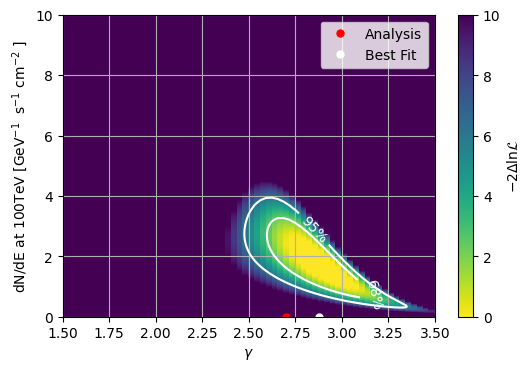

In [57]:
Z = ts_true - mesh_tss

x, y =np.unravel_index(np.argmin(Z), Z.shape)
print(stats.norm.isf(np.mean(bkg_dict['pi0'] > np.max(mesh_tss))))
flux_best = dNdE[x]
gamma_best = gammas[y]
print(gamma_best, flux_best)

fig, ax = plt.subplots ()
pc = ax.pcolormesh (gammas, 1e18*dNdE , Z, cmap='viridis_r', vmin=0, vmax = 10.01)
contour_fracs = [1 - 2*stats.norm.sf(1), 0.95]
dLLHs = stats.chi2.ppf (contour_fracs, 2)
print(dLLHs)
contour_labels = {dLLH: r'{:.0f}$\%$'.format (100*frac) for (dLLH, frac) in zip (dLLHs, contour_fracs)}
cont = ax.contour (gammas, 1e18*dNdE, Z, dLLHs, colors='w')
ax.clabel (cont, inline=True, fmt=contour_labels)
ax.plot (gamma_true, flux_true, '.', ms=10, color='r', label='Analysis')
cb = fig.colorbar (pc)
cb.set_label (r'$-2\Delta\ln\mathcal{L}$')
ax.plot (gamma_best, flux_best, '.', ms=10, color='w', label='Best Fit')

#cb.set_ticks (np.r_[0:10000.1:100])
ax.set_xlabel (r'$\gamma$')
ax.set_ylabel (r'dN/dE at 100TeV [GeV$^{-1}$  s$^{-1}$ cm$^{-2}$ ] ')
ax.set_xlim (1.5, 3.5)
#ax.set_ylim (0, .3e-11)
plt.legend()
ax.grid();

In [58]:
'/data/ana/analyses/mese_cascades/'

'/data/ana/analyses/mese_cascades/'

In [63]:
repo = cy.selections.Repository(local_root='/data/user/ssclafani/data/analyses')
mesespecs = cy.selections.MESEDataSpecs.MESC_2010_2016
ana_mese = cy.get_analysis(
    repo, 'version-001-p01', mesespecs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
MESC_2010_2016
Setting up MESC_2010_2016...
  -> /data/user/ssclafani/data/analyses/mese_cascades/version-001-p01/IC86_2013_MC.npy ...
ln -s /data/ana/analyses/mese_cascades/version-001-p01/IC86_2013_MC.npy /data/user/ssclafani/data/analyses/mese_cascades/version-001-p01/IC86_2013_MC.npy
Reading /data/user/ssclafani/data/analyses/mese_cascades/version-001-p01/IC86_2013_MC.npy ...
  -> /data/user/ssclafani/data/analyses/mese_cascades/version-001-p01/IC79_exp.npy ...
ln -s /data/ana/analyses/mese_cascades/version-001-p01/IC79_exp.npy /data/user/ssclafani/data/analyses/mese_cascades/version-001-p01/IC79_exp.npy
Reading /data/user/ssclafani/data/analyses/mese_cascades/version-001-p01/IC79_exp.npy ...
  -> /data/user/ssclafani/data/analyses/mese_cascades/version-001-p01/IC86_2011_exp.npy ...
ln -s /data/ana/analyses/mese_cascades/version-001-p01/IC86_2011_exp.npy /data/user/ssclafani/data/analyses/mese_cascades/version-001-p01/IC86_2011_exp.npy
Reading /data/user/ss

In [64]:
pi0_map = cy.selections.mrichman_repo.get_template ('Fermi-LAT_pi0_map')
conf = {
    # desired template
    'template': pi0_map,
    # desired baseline spectrum
    'flux':     cy.hyp.PowerLawFlux(2.5),
    # desired fixed spectrum in likelihood
    'fitter_args': dict(gamma=2.5),
    # use signal subtracting likelihood
    'sigsub': True,
    # fastest construction:
    # weight from acceptance parameterization rather
    # than pixel-by-pixel directly from MC
    'fast_weight': True,
    # cache angular-resolution-smeared maps to disk
    'dir': cy.utils.ensure_dir('{}/templates/pi0'.format(ana_dir))
}


mese_tr = cy.get_trial_runner(ana=ana_mese, conf=conf)

<- /data/user/ssclafani/data/analyses//templates/pi0/MESC_2010_2016.template.fastweight.npy    
Restore successful.


In [65]:
Lm =mese_tr.get_one_llh(TRUTH=True,)
MTST  = Lm.fit(gamma=2.5)

In [83]:
MTST

(2.993064236316589, {'ns': 44.160201728284385}, {'gamma': 2.5})

In [66]:
dNdE = np.linspace (0, 10e-18, 2000)
gammas = np.r_[1.0:3.5001:2**-5]

get_ns_from_flux = lambda dNdE,  **params: cy.hyp.PowerLawFlux(params['gamma']).to_ns (dNdE, Lm.get_acc_total (**params), E0=1e5, unit=1, E2dNdE=False)
    
mesh_tss_m, (mesh_fluxs_m, mesh_gammas_m) = Lm.scan_ts (dNdE, gamma=gammas, get_ns_from_arg=get_ns_from_flux)

          gamma
     3.5000e+00
Done.


In [67]:
MTST[0]

2.993064236316589

In [72]:
1-2*stats.norm.sf(1)

0.6826894921370859

4.857873250965904
[2.29574893 5.99146455]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


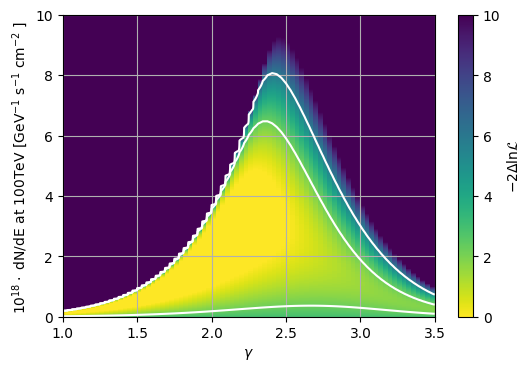

In [68]:
Z = MTST[0] - mesh_tss_m

x, y =np.unravel_index(np.argmin(Z), Z.shape)
print(stats.norm.isf(np.mean(bkg_dict['pi0'] > np.max(mesh_tss))))
flux_best = dNdE[x]
gamma_best = gammas[y]
#print(gamma_best, flux_best)

fig, ax = plt.subplots ()
pc = ax.pcolormesh (gammas, 1e18*dNdE , Z, cmap='viridis_r', vmin=0, vmax = 10.01)
contour_fracs = [1 - 2*stats.norm.sf(1), 0.95]
dLLHs = stats.chi2.ppf (contour_fracs, 2)
print(dLLHs)
contour_labels = {dLLH: r'{:.0f}$\%$'.format (100*frac) for (dLLH, frac) in zip (dLLHs, contour_fracs)}
cont_m = ax.contour (gammas, 1e18*dNdE, Z, dLLHs, colors='w')
ax.clabel (cont, inline=True, fmt=contour_labels)
#ax.plot (gamma_true, flux_true, '.', ms=10, color='r', label='Analysis')
cb = fig.colorbar (pc)
cb.set_label (r'$-2\Delta\ln\mathcal{L}$')
#ax.plot (gamma_best, flux_best, '.', ms=10, color='w', label='Best Fit')

#cb.set_ticks (np.r_[0:10000.1:100])
ax.set_xlabel (r'$\gamma$')
ax.set_ylabel (r'10$^{18} \cdot$ dN/dE at 100TeV [GeV$^{-1}$ s$^{-1}$ cm$^{-2}$ ] ')
ax.set_xlim (1.0, 3.5)
#ax.set_ylim (0, .3e-11)
#plt.legend()
ax.grid();

In [69]:
cont_m

4.857873250965904
2.875 1.7358679339669835e-18
[2.29574893 5.99146455]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


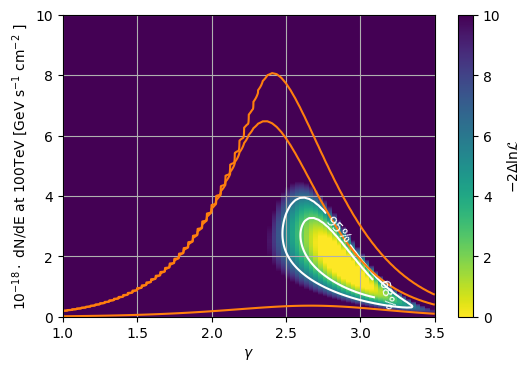

In [70]:
Z = ts_true - mesh_tss

x, y =np.unravel_index(np.argmin(Z), Z.shape)
print(stats.norm.isf(np.mean(bkg_dict['pi0'] > np.max(mesh_tss))))
flux_best = dNdE[x]
gamma_best = gammas[y]
print(gamma_best, flux_best)

fig, ax = plt.subplots ()
pc = ax.pcolormesh (gammas, 1e18*dNdE , Z, cmap='viridis_r', vmin=0, vmax = 10.01)
contour_fracs = [1 - 2*stats.norm.sf(1), 0.95]
dLLHs = stats.chi2.ppf (contour_fracs, 2)
print(dLLHs)
contour_labels = {dLLH: r'{:.0f}$\%$'.format (100*frac) for (dLLH, frac) in zip (dLLHs, contour_fracs)}
cont = ax.contour (gammas, 1e18*dNdE, Z, dLLHs, colors='w')

plt.contour(cont_m, colors=['C1', 'C1'])
ax.clabel (cont, inline=True, fmt=contour_labels)
#ax.plot (gamma_true, flux_true, '.', ms=10, color='r', label='Analysis')
cb = fig.colorbar (pc)
cb.set_label (r'$-2\Delta\ln\mathcal{L}$')
#ax.plot (gamma_best, flux_best, '.', ms=10, color='w', label='Best Fit')

#cb.set_ticks (np.r_[0:10000.1:100])
ax.set_xlabel (r'$\gamma$')
ax.set_ylabel (r'10$^{-18} \cdot$ dN/dE at 100TeV [GeV s$^{-1}$ cm$^{-2}$ ] ')
ax.set_xlim (1.0, 3.5)
#ax.set_ylim (0, .3e-11)
#plt.legend()
ax.grid();

In [92]:
E2dNdE = np.linspace (0, 10e-8, 2000)
gammas = np.r_[1.0:3.5001:2**-5]

get_ns_from_flux = lambda E2dNdE,  **params: cy.hyp.PowerLawFlux(params['gamma']).to_ns (E2dNdE, Lm.get_acc_total (**params), E0=1e5, unit=1, E2dNdE=True)
    
mesh_tss_m, (mesh_fluxs_m, mesh_gammas_m) = Lm.scan_ts (E2dNdE, gamma=gammas, get_ns_from_arg=get_ns_from_flux)

          gamma
     3.5000e+00
Done.


In [93]:
np.max(mesh_tss_m)

4.153640529069516

4.857873250965904
[2.29574893 5.99146455]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


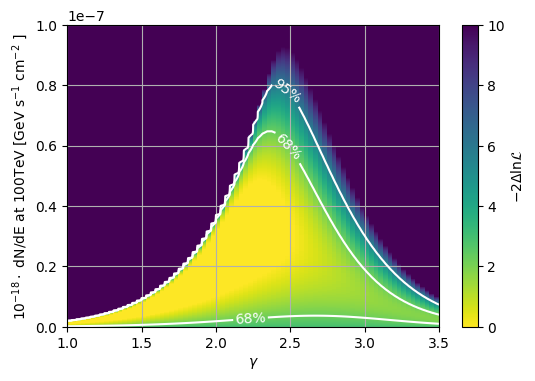

In [94]:
Z = MTST[0] - mesh_tss_m

x, y =np.unravel_index(np.argmin(Z), Z.shape)
print(stats.norm.isf(np.mean(bkg_dict['pi0'] > np.max(mesh_tss))))
#flux_best = dNdE[x]
#gamma_best = gammas[y]
#print(gamma_best, flux_best)

fig, ax = plt.subplots ()
pc = ax.pcolormesh (gammas, E2dNdE , Z, cmap='viridis_r', vmin=0, vmax = 10.01)
contour_fracs = [1 - 2*stats.norm.sf(1), 0.95]
dLLHs = stats.chi2.ppf (contour_fracs, 2)
print(dLLHs)
contour_labels = {dLLH: r'{:.0f}$\%$'.format (100*frac) for (dLLH, frac) in zip (dLLHs, contour_fracs)}
cont = ax.contour (gammas,E2dNdE, Z, dLLHs, colors='w')

#plt.contour(cont_m, colors=['C1', 'C1'])
ax.clabel (cont, inline=True, fmt=contour_labels)
#ax.plot (gamma_true, flux_true, '.', ms=10, color='r', label='Analysis')
cb = fig.colorbar (pc)
cb.set_label (r'$-2\Delta\ln\mathcal{L}$')
#ax.plot (gamma_best, flux_best, '.', ms=10, color='w', label='Best Fit')

#cb.set_ticks (np.r_[0:10000.1:100])
ax.set_xlabel (r'$\gamma$')
ax.set_ylabel (r'10$^{-18} \cdot$ dN/dE at 100TeV [GeV s$^{-1}$ cm$^{-2}$ ] ')
ax.set_xlim (1.0, 3.5)
#ax.set_ylim (0, .3e-11)
#plt.legend()
ax.grid();